In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['test', 'train.csv', 'sample_submission.csv']


In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV

In [7]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [8]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15
# much better!
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [9]:
from sklearn.linear_model import LinearRegression
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

from scipy import stats

In [10]:
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','q95','q99', 'q05','q01',
                               'abs_max', 'abs_mean', 'abs_std', 'trend', 'abs_trend', 'iqr', 
                                'q999','q001','ave10'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'q95'] = np.quantile(x,0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x,0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x,0.05)
    X_train.loc[segment, 'q01'] = np.quantile(x,0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x).std()
    X_train.loc[segment, 'trend'] = add_trend_feature(x)
    X_train.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    
    X_train.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_train.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_train.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_train.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

100%|██████████| 4194/4194 [06:45<00:00, 10.58it/s]


In [11]:
X_train.head()

,ave,std,max,min,q95,q99,q05,q01,abs_max,abs_mean,abs_std,trend,abs_trend,iqr,q999,q001,ave10
0,4.884113333333334,5.101089126891323,104.0,-98.0,11.0,18.0,-2.0,-8.0,104.0,5.576566666666666,4.333310229553795,-0.000003268299817,-0.000011278536937,4.0,40.00000000000000,-30.0,4.869341666666666
1,4.725766666666667,6.588801819164257,181.0,-154.0,12.0,21.0,-2.0,-11.0,181.0,5.734166666666667,5.732757856292980,0.000000909042448,-0.000005389409165,5.0,59.00000000000000,-47.0,4.724200000000000
2,4.906393333333333,6.967373808828945,140.0,-106.0,13.0,26.0,-3.0,-15.0,140.0,6.152646666666667,5.895925061301991,0.000003962181680,0.000009924271312,5.0,59.00000000000000,-47.0,4.894825000000000
3,4.902240000000000,6.922282112791032,197.0,-199.0,12.0,22.0,-2.0,-12.0,199.0,5.933960000000000,6.061193396111583,0.000001637207225,-0.000002255140491,5.0,60.00099999998929,-50.0,4.894383333333334
4,4.908720000000000,7.301085852684289,145.0,-126.0,12.0,26.0,-2.0,-15.0,145.0,6.110586666666666,6.329464215541647,-0.000000666839221,0.000004691516491,5.0,65.00000000000000,-56.0,4.895833333333333


In [12]:


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [13]:
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
parameters = [{ 'gamma': [0.6, 0.7, 0.8],
               'C': [2.35, 2.4, 2.45, 2.5],
              'nu': [0.85, 0.9, 0.95]}]

reg1 = GridSearchCV(NuSVR(kernel='rbf', tol=0.01), parameters, cv = 3, scoring=scorer)
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print(reg1.best_params_)
print(reg1.best_score_)

{'C': 2.35, 'gamma': 0.6, 'nu': 0.85}
-2.3089424635941582


In [14]:
parameters = [{ 'gamma': [0.06, 0.1, 0.08, 0.09], #np.logspace(-2, 2, 5)
               'alpha': [0.005, 0.01, 0.05]}]

reg2 = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv = 3, scoring=scorer)
reg2.fit(X_train_scaled, y_train.values.flatten())
y_pred2 = reg2.predict(X_train_scaled)

print(reg2.best_params_)
print(reg2.best_score_)

{'alpha': 0.05, 'gamma': 0.06}
-2.2657596625814826


<Figure size 432x288 with 0 Axes>

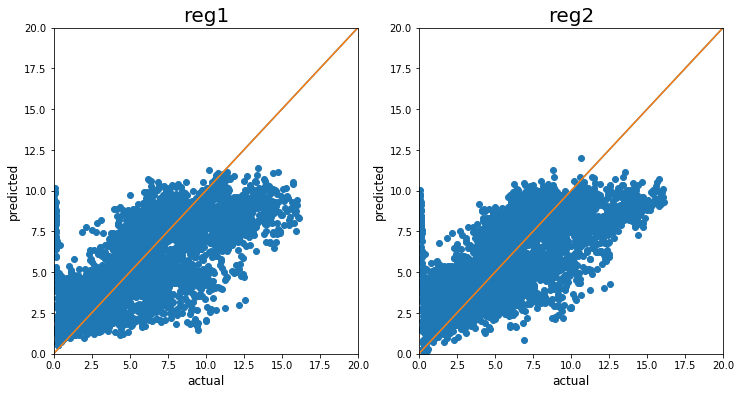

In [15]:
plt.tight_layout()
f = plt.figure(figsize=(12, 6))
f.add_subplot(1,2, 1)
plt.scatter(y_train.values.flatten(), y_pred1)
plt.title('reg1', fontsize=20)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
f.add_subplot(1,2, 2)
plt.scatter(y_train.values.flatten(), y_pred2)
plt.title('reg2', fontsize=20)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show(block=True)

In [16]:
score1 = mean_absolute_error(y_train.values.flatten(), y_pred1)
print(f'Score1: {score1:0.3f}')
score2 = mean_absolute_error(y_train.values.flatten(), y_pred2)
print(f'Score2: {score2:0.3f}')
score3 = mean_absolute_error(y_train.values.flatten(), y_pred1*0.5+y_pred2*0.5)
print(f'Score3: {score3:0.3f}')

Score1: 1.861
Score2: 2.009
Score3: 1.915


In [18]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)

In [23]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = reg1.predict(X_test_scaled)*0.5 + reg2.predict(X_test_scaled)*0.5
submission.to_csv('submission.csv')
print(os.getcwd())

/kaggle/working
